In [1]:
from matplotlib import pyplot
from math import pi
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import numba
from numba import jit

In [2]:
def uex(t,X,Y):
    return -numpy.exp(-2*t)*numpy.cos(X)*numpy.sin(Y)

def vex(t,X,Y):
    return numpy.exp(-2*t)*numpy.sin(X)*numpy.cos(Y)

def pex(t,X,Y):
    return -numpy.exp(-4*t)/4.*(numpy.cos(2*X)+numpy.cos(2*Y))

In [3]:
def Fc1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=-((u[1:-1,1:-1]+u[1:-1,2:])**2-(u[1:-1,1:-1]+u[1:-1,:-2])**2)/(4*dx)-\
                ((u[1:-1,1:-1]+u[2:,1:-1])*(v[1:-1,2:]+v[1:-1,1:-1])-(u[1:-1,1:-1]+u[:-2,1:-1])*(v[:-2,2:]+v[:-2,1:-1]))/(4*dy)
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [4]:
def Fv1(u,v,dx,dy):
    F=numpy.zeros(numpy.shape(u))
    F[1:-1,1:-1]=(u[1:-1,2:]-2*u[1:-1,1:-1]+u[1:-1,:-2])/dx**2+(u[2:,1:-1]-2*u[1:-1,1:-1]+u[:-2,1:-1])/dy**2
    
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [5]:
def Fp1(p,dx,dy):
    F=numpy.zeros(numpy.shape(p))
    F[1:-1,1:-1]=-(p[1:-1,2:]-p[1:-1,1:-1])/dx
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [6]:
def Fc2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=-((u[2:,1:-1]+u[1:-1,1:-1])*(v[1:-1,1:-1]+v[1:-1,2:])-(u[2:,:-2]+u[1:-1,:-2])*(v[1:-1,1:-1]+v[1:-1,:-2]))/(4*dx)-\
                 ((v[1:-1,1:-1]+[v[2:,1:-1]])**2-(v[1:-1,1:-1]+v[:-2,1:-1])**2)/(4*dy)
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [7]:
def Fv2(u,v,dx,dy):
    F=numpy.zeros((numpy.shape(u)))
    F[1:-1,1:-1]=(v[1:-1,2:]-2*v[1:-1,1:-1]+v[1:-1,:-2])/dx**2+(v[2:,1:-1]-2*v[1:-1,1:-1]+v[:-2,1:-1])/dy**2
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [8]:
def Fp2(p,dx,dy):
    F=numpy.zeros((numpy.shape(p)))
    F[1:-1,1:-1]=-(p[2:,1:-1]-p[1:-1,1:-1])/dy
        
    F[:,0]=F[:,-2]
    F[:,-1]=F[:,1]
    F[0,:]=F[-2,:]
    F[-1,:]=F[-1,:]
    return F

In [9]:
@jit
def poisson(f,res_target,omega):
    nj,ni=numpy.shape(f)-numpy.array((1,1))
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    
    p=numpy.zeros(numpy.shape(f))
    res=numpy.zeros(numpy.shape(f))
    
    res_max=1e3
    n=0
    while res_max>res_target:
        
        for j in range(1,nj):
            for i in range(1,ni):
                p[j,i]=omega/(2*(dx**2+dy**2))*((p[j,i-1]+p[j,i+1])*dy**2+\
                       (p[j-1,i]+p[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*p[j,i]
        p[0,:]=p[1,:]
        p[-1,:]=p[-2,:]
        p[:,0]=p[:,1]
        p[:,-1]=p[:,-2]
        n+=1
        
        for j in range(1,nj):
            for i in range(1,ni):
                res[j,i]=numpy.abs(f[j,i]-(p[j,i-1]-2*p[j,i]+p[j,i+1])/dx**2-\
                                  (p[j-1,i]-2*p[j,i]+p[j+1,i])/dy**2)
        res_max=numpy.max(res)
    
    return p

In [10]:
@jit
def getuv(w1,w2,p,dx,dy,dt):
    u=w1+Fp1(p,dx,dy)*dt
    v=w2+Fp2(p,dx,dy)*dt
    
    u[0,:]=-u[1,:]
    u[-1,:]=-u[-2,:]
    u[:,0]=u[:,-2]
    u[:,-1]=u[:,1]

    v[0,:]=v[-2,:]
    v[-1,:]=v[1,:]
    v[:,0]=-v[:,1]
    v[:,-1]=-v[:,-2]
    return u,v

In [11]:
@jit
def error(p,p_ex):
    nj,ni=numpy.shape(p)-numpy.array((1,1))
    err=numpy.zeros(numpy.shape(p))
    for j in range(nj+1):
        for i in range(ni+1):
            err[j,i]=numpy.abs(p[j,i]-p_ex[j,i])
    err_max=numpy.mean(err[2:-2,2:-2])
    return err_max

In [12]:
@jit
def RK3(ni,nj,dt):
    T=2.
    t=0.
    dx=2.*pi/(ni-1)
    dy=2.*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)

    X,Y=numpy.meshgrid(x,y)
    Xu,Yu=numpy.meshgrid(xu,yu)
    Xv,Yv=numpy.meshgrid(xv,yv)

    u0=uex(0,Xu,Yu)
    v0=vex(0,Xv,Yv)
    p0=pex(0,X,Y)
            
    u=u0.copy()
    v=v0.copy()
    p=p0.copy()
    res=numpy.zeros((nj+1,ni+1))
    nt=0
    
    while t<T:
        G1=numpy.zeros((nj+1,ni+1))
        G2=numpy.zeros((nj+1,ni+1))
        w1=numpy.zeros((nj+1,ni+1))
        w2=numpy.zeros((nj+1,ni+1)) 
        f=numpy.zeros((nj+1,ni+1))
        
        #from t to t+dt/3
        #t+=dt/3
        G1=Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt/3*G1
        w2=v+dt/3*G2
        f[1:-1,1:-1]=3./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1e-9,1.99)
        u,v=getuv(w1,w2,p,dx,dy,dt/3)
        
        #from t+dt/3 to t+3dt/4
        #t+=5/12*dt
        G1=-5./9*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-5./9*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*15./16*G1
        w2=v+dt*15./16*G2
        f[1:-1,1:-1]=12./5/dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1e-9,1.99)
        u,v=getuv(w1,w2,p,dx,dy,5.*dt/12)
        
        #from t+3dt/4 to t+dt
        #t+=dt/4
        G1=-153./128*G1+Fc1(u,v,dx,dy)+Fv1(u,v,dx,dy)
        G2=-153./128*G2+Fc2(u,v,dx,dy)+Fv2(u,v,dx,dy)
        w1=u+dt*8./15*G1
        w2=v+dt*8./15*G2
        f[1:-1,1:-1]=4./dt*((w1[1:-1,1:-1]-w1[1:-1,:-2])/dx+(w2[1:-1,1:-1]-w2[:-2,1:-1])/dy)
        p=poisson(f,1e-9,1.99)
        u,v=getuv(w1,w2,p,dx,dy,dt/4)
        
        
        if nt%500==0:
            print(int(t/dt),error(u,uex(t,Xu,Yu)),error(v,vex(t,Xv,Yv)),error(p,pex(t,X,Y)))
        nt+=1
        t+=dt
    
    omega=numpy.zeros((nj+1,ni+1))
    for i in range(1,ni+1):
        for j in range(1,nj+1):
            omega[j,i]=(v[j,i]-v[j,i-1])/dx-(u[j,i]-u[j-1,i])/dy
    omega[0,:]=omega[-2,:]
    omega[:,0]=omega[:,-2]
    
    A=numpy.array([u,v,p,omega])
    return A

In [13]:
def grid_p(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    x=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    y=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(x,y)
    return X,Y

def grid_u(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xu=numpy.linspace(0,2*pi+dx,ni+1)
    yu=numpy.linspace(-dy/2,2*pi+dy/2,nj+1)
    X,Y=numpy.meshgrid(xu,yu)
    return X,Y

def grid_v(ni,nj):
    dx=2*pi/(ni-1)
    dy=2*pi/(nj-1)
    xv=numpy.linspace(-dx/2,2*pi+dx/2,ni+1)
    yv=numpy.linspace(0,2*pi+dy,nj+1)
    X,Y=numpy.meshgrid(xv,yv)
    return X,Y

In [14]:
X1,Y1=grid_p(21,21)
Xu1,Yu1=grid_u(21,21)
Xv1,Yv1=grid_v(21,21)

In [15]:
print('nt        u error         v error           p error')
A1_1=RK3(21,21,1e-3)

nt        u error         v error           p error
0 0.000814410920042 0.000814410920042 0.20869222767
500 0.000942431499587 0.000942431499588 0.028828501844
1000 0.000807381946466 0.000807381946466 0.00398200435828
1499 0.00046788921295 0.00046788921295 0.000549979016371
1999 0.000235503799146 0.000235503799147 7.595495072e-05


In [16]:
print('nt        u error         v error           p error')
A1_2=RK3(21,21,5e-4)

nt        u error         v error           p error
0 0.000407407393553 0.000407407393553 0.209080722617
500 0.000775696536021 0.000775696536021 0.0777096227448
1000 0.00109339223834 0.00109339223834 0.0288819480629
1499 0.00104254079281 0.00104254079281 0.0107341868267
1999 0.000863374445692 0.000863374445692 0.00398935708946
2499 0.000664372383152 0.000664372383152 0.00148261324835
2999 0.000488657261622 0.000488657261622 0.00055099055043
3499 0.000348575762229 0.000348575762229 0.00020476316691
3999 0.000243206828152 0.000243206828152 7.60941100505e-05


In [17]:
print('nt        u error         v error           p error')
A1_3=RK3(21,21,2.5e-4)

nt        u error         v error           p error
0 0.000203754205219 0.000203754205219 0.209275404862
500 0.000497620206459 0.000497620206459 0.127584914079
1000 0.000899725777409 0.000899725777409 0.0777818318696
1499 0.00110041068749 0.00110041068749 0.0474192553745
1999 0.0011689287563 0.0011689287563 0.0289087309748
2499 0.00115379081578 0.00115379081578 0.0176238616213
2999 0.00108854418267 0.00108854418267 0.0107441208073
3499 0.00099601214003 0.00099601214003 0.00654995729716
3999 0.000891391515262 0.000891391515262 0.00399304167949
4499 0.000784505770734 0.000784505770734 0.00243426032822
5000 0.000681435390683 0.000681435390683 0.00148397988968
5500 0.000585690607305 0.000585690607305 0.00090466302395
6000 0.000499049006028 0.000499049006028 0.000551497447581
6500 0.000422148765531 0.000422148765531 0.000336200247878
7000 0.000354904561628 0.000354904561628 0.000204951179006
7500 0.000296795487886 0.000296795487886 0.000124939767495


In [18]:
X2,Y2=grid_p(41,41)
Xu2,Yu2=grid_u(41,41)
Xv2,Yv2=grid_v(41,41)

In [19]:
print('nt        u error         v error           p error')
A2_1=RK3(41,41,1e-3)

nt        u error         v error           p error
0 0.000819437298063 0.000819437298063 0.20348358933
500 8.85774122603e-06 8.85774122601e-06 0.0276663798698
1000 0.000117650715354 0.000117650715354 0.00376161402321
1499 8.5450340342e-05 8.5450340342e-05 0.000511440458178
1999 4.69804581504e-05 4.69804581504e-05 6.95368302807e-05


In [20]:
print('nt        u error         v error           p error')
A2_2=RK3(41,41,5e-4)

nt        u error         v error           p error
0 0.000409923087341 0.000409923087341 0.203826578011
500 7.3019024255e-06 7.30190242551e-06 0.0751574828724
1000 0.000159819472993 0.000159819472993 0.0277129894838
1499 0.000191281467138 0.000191281467138 0.0102186674299
1999 0.000173300663168 0.000173300663168 0.00376794792325
2499 0.000139891520234 0.000139891520234 0.00138936149154
2999 0.00010596492146 0.00010596492146 0.000512301188098
3499 7.70918965349e-05 7.70918965349e-05 0.000188901414183
3999 5.45428738392e-05 5.45428738392e-05 6.96537970833e-05


In [21]:
print('nt        u error         v error           p error')
A2_3=RK3(41,41,2.5e-4)

nt        u error         v error           p error
0 0.000205012678776 0.000205012678776 0.203998458561
500 4.68788272298e-06 4.68788272298e-06 0.123874689094
1000 0.000131714087601 0.000131714087601 0.0752208442355
1499 0.000202365963856 0.000202365963856 0.0456765994167
1999 0.000235356835525 0.000235356835525 0.0277363467628
2499 0.000243882124222 0.000243882124222 0.0168424275365
2999 0.000237144282994 0.000237144282994 0.0102272777637
3499 0.00022147320956 0.00022147320956 0.00621033960521
3999 0.000201146457722 0.000201146457722 0.00377112200343
4499 0.000178987214001 0.000178987214001 0.00228994868723
5000 0.000156798207279 0.000156798207279 0.00139053157188
5500 0.000135674863279 0.000135674863279 0.000844376021579
6000 0.000116229885036 0.000116229885036 0.000512732521779
6500 9.8753114272e-05 9.8753114272e-05 0.000311347780169
7000 8.33243107824e-05 8.33243107824e-05 0.000189060419332
7500 6.98918522523e-05 6.98918522523e-05 0.000114803570564


In [22]:
X3,Y3=grid_p(61,61)
Xu3,Yu3=grid_u(61,61)
Xv3,Yv3=grid_v(61,61)

In [23]:
print('nt        u error         v error           p error')
A3_1=RK3(61,61,1e-3)

nt        u error         v error           p error
0 0.000817906049441 0.000817906049441 0.18984207003
500 0.000163405175749 0.000163405175749 0.025743557701
1000 9.48903746515e-06 9.48903746514e-06 0.00349095722364
1499 1.51498629646e-05 1.51498629646e-05 0.000473391381641
1999 1.24371151496e-05 1.24371151496e-05 6.41942346081e-05


In [24]:
print('nt        u error         v error           p error')
A3_2=RK3(61,61,5e-4)

nt        u error         v error           p error
0 0.000409157314304 0.000409157314304 0.190151802283
500 0.000134741285332 0.000134741285332 0.070022636353
1000 1.28974469229e-05 1.28974469229e-05 0.0257855520738
1499 3.3942226918e-05 3.3942226918e-05 0.00949542427987
1999 4.59302812668e-05 4.59302812668e-05 0.00349665093957
2499 4.323662279e-05 4.323662279e-05 0.00128762722264
2999 3.55561298919e-05 3.55561298919e-05 0.000474163351735
3499 2.72284870657e-05 2.72284870657e-05 0.000174608661426
3999 1.99510243682e-05 1.99510243682e-05 6.42989004975e-05


In [25]:
print('nt        u error         v error           p error')
A3_3=RK3(61,61,2.5e-4)

nt        u error         v error           p error
0 0.000204629755086 0.000204629755086 0.190307017566
500 8.65173432075e-05 8.65173432075e-05 0.115484526752
1000 1.06323704616e-05 1.06323704616e-05 0.0700797890547
1499 3.59245187342e-05 3.59245187342e-05 0.0425267078749
1999 6.24128086125e-05 6.24128086125e-05 0.0258065965961
2499 7.54310917367e-05 7.54310917367e-05 0.0156602861478
2999 7.96410761533e-05 7.96410761533e-05 0.00950317320254
3499 7.83015120169e-05 7.83015120169e-05 0.00576683581788
3999 7.36606986792e-05 7.36606986792e-05 0.00349950421438
4499 6.72440073374e-05 6.72440073374e-05 0.00212361334371
5000 6.00636559227e-05 6.00636559227e-05 0.00128867784309
5500 5.2771061024e-05 5.2771061024e-05 0.000782011732122
6000 4.57669045743e-05 4.57669045743e-05 0.000474550206705
6500 3.92801662767e-05 3.92801662767e-05 0.000287972526194
7000 3.34244646211e-05 3.34244646211e-05 0.000174751107506
7500 2.82378772242e-05 2.82378772242e-05 0.000106044661058


In [26]:
X4,Y4=grid_p(81,81)
Xu4,Yu4=grid_u(81,81)
Xv4,Yv4=grid_v(81,81)

In [27]:
print('nt        u error         v error           p error')
A4_1=RK3(81,81,1e-3)

nt        u error         v error           p error
0 0.000816510523026 0.000816510523026 0.176903272581
500 0.000223207707889 0.000223207707889 0.0239676545345
1000 5.37097768319e-05 5.37097768319e-05 0.00324724584543
1499 9.30419543096e-06 9.30419543096e-06 0.00043995146476
1999 4.25160537079e-07 4.25160537106e-07 5.96065973773e-05


In [28]:
print('nt        u error         v error           p error')
A4_2=RK3(81,81,5e-4)

nt        u error         v error           p error
0 0.000408459284099 0.000408459284099 0.177187223886
500 0.000184071924711 0.000184071924711 0.0652194627723
1000 7.30168336837e-05 7.30168336837e-05 0.0240061227001
1499 2.08515984526e-05 2.08515984526e-05 0.00883622604099
1999 1.57077752081e-06 1.57077752081e-06 0.0032524573014
2499 9.57854011264e-06 9.57854011264e-06 0.0011971715338
2999 1.10428443346e-05 1.10428443346e-05 0.000440657484244
3499 9.87271507576e-06 9.87271507577e-06 0.000162198155412
3999 7.91426827243e-06 7.91426827245e-06 5.97022450516e-05


In [29]:
print('nt        u error         v error           p error')
A4_3=RK3(81,81,2.5e-4)

nt        u error         v error           p error
0 0.000204280673211 0.000204280673211 0.177329519763
500 0.000118198449056 0.000118198449056 0.107585424854
1000 6.01995054674e-05 6.01995054674e-05 0.0652718374127
1499 2.20726731386e-05 2.20726731386e-05 0.0396002780411
1999 2.13489832523e-06 2.13489832523e-06 0.0240254001598
2499 1.67150078378e-05 1.67150078377e-05 0.0145761564921
2999 2.47419473836e-05 2.47419473836e-05 0.0088433214678
3499 2.84011045113e-05 2.84011045113e-05 0.00536522328256
3999 2.9231769042e-05 2.9231769042e-05 0.0032550689052
4499 2.83060203838e-05 2.83060203838e-05 0.00197484297785
5000 2.63600919364e-05 2.63600919364e-05 0.00119813278305
5500 2.38904831023e-05 2.38904831023e-05 0.000726904455067
6000 2.12239863011e-05 2.12239863011e-05 0.000441011289918
6500 1.85684658144e-05 1.85684658144e-05 0.000267560551407
7000 1.60494770839e-05 1.60494770839e-05 0.00016232838014
7500 1.37365057666e-05 1.37365057666e-05 9.84842598361e-05


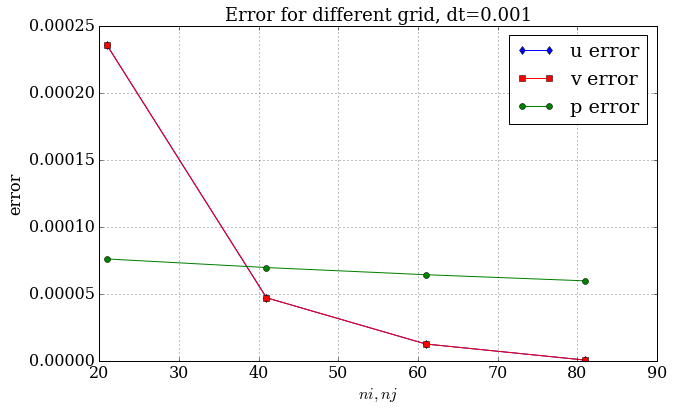

In [30]:
u_grid1=numpy.zeros(4)
u_grid1[0]=error(A1_1[0],uex(2,Xu1,Yu1))
u_grid1[1]=error(A2_1[0],uex(2,Xu2,Yu2))
u_grid1[2]=error(A3_1[0],uex(2,Xu3,Yu3))
u_grid1[3]=error(A4_1[0],uex(2,Xu4,Yu4))

v_grid1=numpy.zeros(4)
v_grid1[0]=error(A1_1[1],vex(2,Xv1,Yv1))
v_grid1[1]=error(A2_1[1],vex(2,Xv2,Yv2))
v_grid1[2]=error(A3_1[1],vex(2,Xv3,Yv3))
v_grid1[3]=error(A4_1[1],vex(2,Xv4,Yv4))

p_grid1=numpy.zeros(4)
p_grid1[0]=error(A1_1[2],pex(2,X1,Y1))
p_grid1[1]=error(A2_1[2],pex(2,X2,Y2))
p_grid1[2]=error(A3_1[2],pex(2,X3,Y3))
p_grid1[3]=error(A4_1[2],pex(2,X4,Y4))

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni,nj$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(21,81,4),u_grid1,color='b',marker='d')
pyplot.plot(numpy.linspace(21,81,4),v_grid1,color='r',marker='s')
pyplot.plot(numpy.linspace(21,81,4),p_grid1,color='g',marker='o')
pyplot.title('Error for different grid, dt=0.001',fontsize=18)
pyplot.legend(['u error','v error','p error'],loc='best')

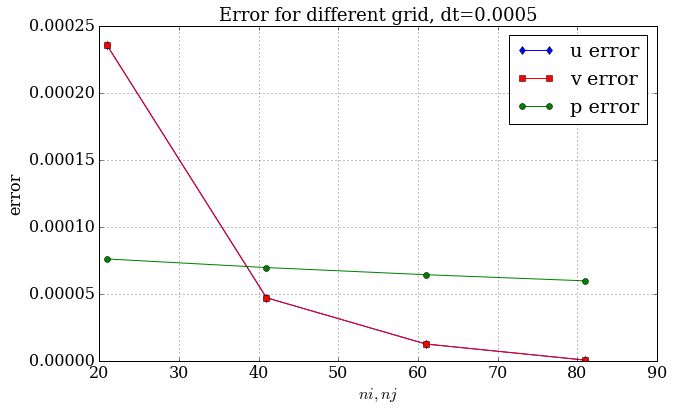

In [31]:
u_grid2=numpy.zeros(4)
u_grid2[0]=error(A1_2[0],uex(2,Xu1,Yu1))
u_grid2[1]=error(A2_2[0],uex(2,Xu2,Yu2))
u_grid2[2]=error(A3_2[0],uex(2,Xu3,Yu3))
u_grid2[3]=error(A4_2[0],uex(2,Xu4,Yu4))

v_grid2=numpy.zeros(4)
v_grid2[0]=error(A1_2[1],vex(2,Xv1,Yv1))
v_grid2[1]=error(A2_2[1],vex(2,Xv2,Yv2))
v_grid2[2]=error(A3_2[1],vex(2,Xv3,Yv3))
v_grid2[3]=error(A4_2[1],vex(2,Xv4,Yv4))

p_grid2=numpy.zeros(4)
p_grid2[0]=error(A1_2[2],pex(2,X1,Y1))
p_grid2[1]=error(A2_2[2],pex(2,X2,Y2))
p_grid2[2]=error(A3_2[2],pex(2,X3,Y3))
p_grid2[3]=error(A4_2[2],pex(2,X4,Y4))

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni,nj$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(21,81,4),u_grid1,color='b',marker='d')
pyplot.plot(numpy.linspace(21,81,4),v_grid1,color='r',marker='s')
pyplot.plot(numpy.linspace(21,81,4),p_grid1,color='g',marker='o')
pyplot.title('Error for different grid, dt=0.0005',fontsize=18)
pyplot.legend(['u error','v error','p error'],loc='best')

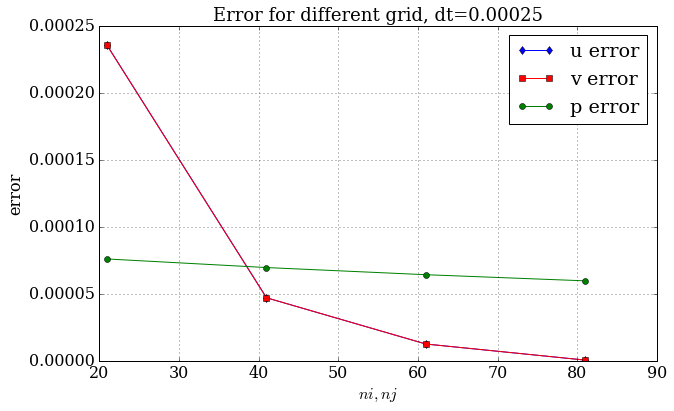

In [32]:
u_grid3=numpy.zeros(4)
u_grid3[0]=error(A1_3[0],uex(2,Xu1,Yu1))
u_grid3[1]=error(A2_3[0],uex(2,Xu2,Yu2))
u_grid3[2]=error(A3_3[0],uex(2,Xu3,Yu3))
u_grid3[3]=error(A4_3[0],uex(2,Xu4,Yu4))

v_grid3=numpy.zeros(4)
v_grid3[0]=error(A1_3[1],vex(2,Xv1,Yv1))
v_grid3[1]=error(A2_3[1],vex(2,Xv2,Yv2))
v_grid3[2]=error(A3_3[1],vex(2,Xv3,Yv3))
v_grid3[3]=error(A4_3[1],vex(2,Xv4,Yv4))

p_grid3=numpy.zeros(4)
p_grid3[0]=error(A1_3[2],pex(2,X1,Y1))
p_grid3[1]=error(A2_3[2],pex(2,X2,Y2))
p_grid3[2]=error(A3_3[2],pex(2,X3,Y3))
p_grid3[3]=error(A4_3[2],pex(2,X4,Y4))

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$ni,nj$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(21,81,4),u_grid1,color='b',marker='d')
pyplot.plot(numpy.linspace(21,81,4),v_grid1,color='r',marker='s')
pyplot.plot(numpy.linspace(21,81,4),p_grid1,color='g',marker='o')
pyplot.title('Error for different grid, dt=0.00025',fontsize=18)
pyplot.legend(['u error','v error','p error'],loc='best')

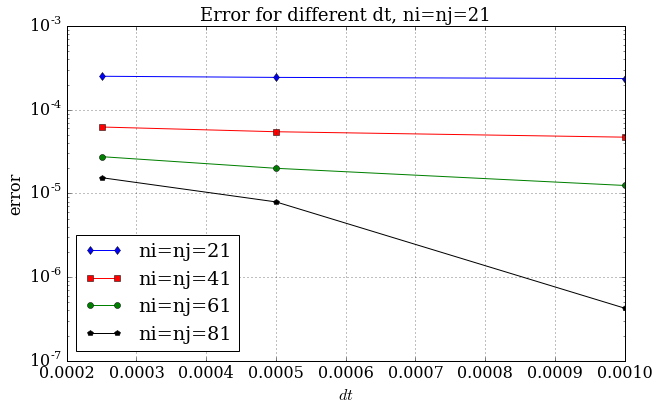

In [42]:
u_time1=numpy.zeros(3)
u_time1[0]=error(A1_1[0],uex(2,Xu1,Yu1))
u_time1[1]=error(A1_2[0],uex(2,Xu1,Yu1))
u_time1[2]=error(A1_3[0],uex(2,Xu1,Yu1))

u_time2=numpy.zeros(3)
u_time2[0]=error(A2_1[0],uex(2,Xu2,Yu2))
u_time2[1]=error(A2_2[0],uex(2,Xu2,Yu2))
u_time2[2]=error(A2_3[0],uex(2,Xu2,Yu2))

u_time3=numpy.zeros(3)
u_time3[0]=error(A3_1[0],uex(2,Xu3,Yu3))
u_time3[1]=error(A3_2[0],uex(2,Xu3,Yu3))
u_time3[2]=error(A3_3[0],uex(2,Xu3,Yu3))

u_time4=numpy.zeros(3)
u_time4[0]=error(A4_1[0],uex(2,Xu4,Yu4))
u_time4[1]=error(A4_2[0],uex(2,Xu4,Yu4))
u_time4[2]=error(A4_3[0],uex(2,Xu4,Yu4))



pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$dt$')
pyplot.ylabel('error')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),u_time1,color='b',marker='d')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),u_time2,color='r',marker='s')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),u_time3,color='g',marker='o')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),u_time4,color='k',marker='p')
pyplot.title('u error for different dt',fontsize=18)
pyplot.legend(['ni=nj=21','ni=nj=41','ni=nj=61','ni=nj=81'],loc='best')

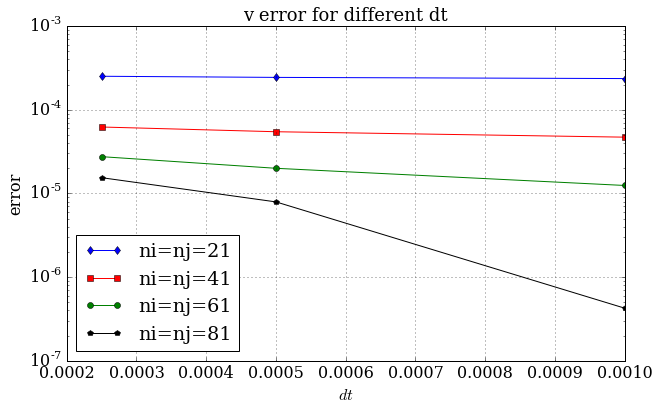

In [43]:
v_time1=numpy.zeros(3)
v_time1[0]=error(A1_1[1],vex(2,Xv1,Yv1))
v_time1[1]=error(A1_2[1],vex(2,Xv1,Yv1))
v_time1[2]=error(A1_3[1],vex(2,Xv1,Yv1))

v_time2=numpy.zeros(3)
v_time2[0]=error(A2_1[1],vex(2,Xv2,Yv2))
v_time2[1]=error(A2_2[1],vex(2,Xv2,Yv2))
v_time2[2]=error(A2_3[1],vex(2,Xv2,Yv2))

v_time3=numpy.zeros(3)
v_time3[0]=error(A3_1[1],vex(2,Xv3,Yv3))
v_time3[1]=error(A3_2[1],vex(2,Xv3,Yv3))
v_time3[2]=error(A3_3[1],vex(2,Xv3,Yv3))

v_time4=numpy.zeros(3)
v_time4[0]=error(A4_1[1],vex(2,Xv4,Yv4))
v_time4[1]=error(A4_2[1],vex(2,Xv4,Yv4))
v_time4[2]=error(A4_3[1],vex(2,Xv4,Yv4))

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$dt$')
pyplot.ylabel('error')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),v_time1,color='b',marker='d')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),v_time2,color='r',marker='s')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),v_time3,color='g',marker='o')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),v_time4,color='k',marker='p')
pyplot.title('v error for different dt',fontsize=18)
pyplot.legend(['ni=nj=21','ni=nj=41','ni=nj=61','ni=nj=81'],loc='best')

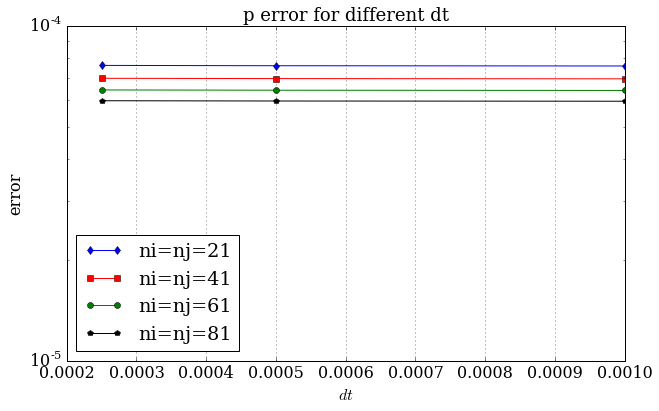

In [44]:
p_time1=numpy.zeros(3)
p_time1[0]=error(A1_1[2],pex(2,X1,Y1))
p_time1[1]=error(A1_2[2],pex(2,X1,Y1))
p_time1[2]=error(A1_3[2],pex(2,X1,Y1))

p_time2=numpy.zeros(3)
p_time2[0]=error(A2_1[2],pex(2,X2,Y2))
p_time2[1]=error(A2_2[2],pex(2,X2,Y2))
p_time2[2]=error(A2_3[2],pex(2,X2,Y2))

p_time3=numpy.zeros(3)
p_time3[0]=error(A3_1[2],pex(2,X3,Y3))
p_time3[1]=error(A3_2[2],pex(2,X3,Y3))
p_time3[2]=error(A3_3[2],pex(2,X3,Y3))

p_time4=numpy.zeros(3)
p_time4[0]=error(A4_1[2],pex(2,X4,Y4))
p_time4[1]=error(A4_2[2],pex(2,X4,Y4))
p_time4[2]=error(A4_3[2],pex(2,X4,Y4))

pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$dt$')
pyplot.ylabel('error')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),p_time1,color='b',marker='d')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),p_time2,color='r',marker='s')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),p_time3,color='g',marker='o')
pyplot.semilogy(numpy.array([1e-3,5e-4,2.5e-4]),p_time4,color='k',marker='p')
pyplot.title('p error for different dt',fontsize=18)
pyplot.legend(['ni=nj=21','ni=nj=41','ni=nj=61','ni=nj=81'],loc='best')

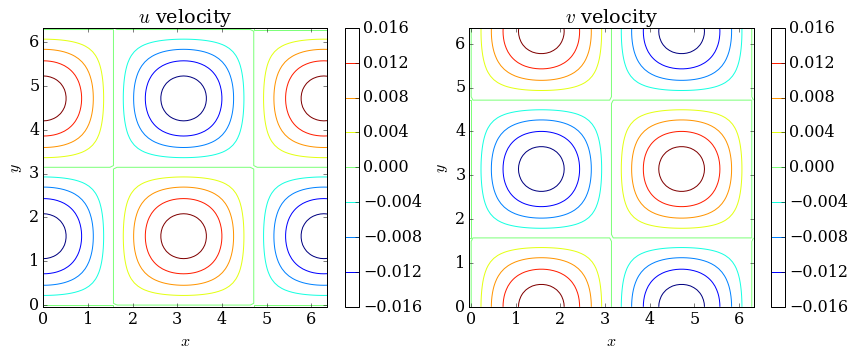

In [33]:
pyplot.figure(figsize=(14,5))
pyplot.subplot(121)
pyplot.contour(Xu4,Yu4,A4_3[0],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$u$ velocity')

pyplot.subplot(122)
pyplot.contour(Xv4,Yv4,A4_3[1],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$v$ velocity');

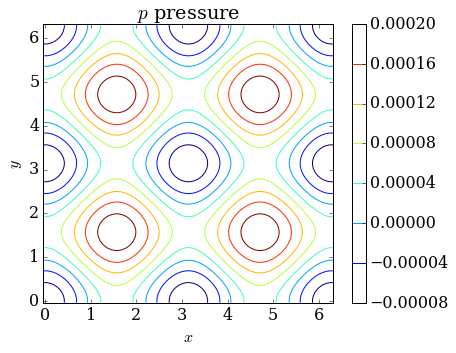

In [34]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X4,Y4,A4_3[2],10)
pyplot.colorbar()
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('$p$ pressure');

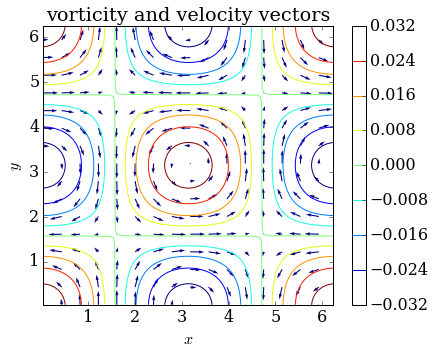

In [39]:
pyplot.figure(figsize=(6.5,5))
pyplot.contour(X4[1:-1,1:-1],Y4[1:-1,1:-1],A4_3[3][1:-1,1:-1],10)
pyplot.colorbar()
pyplot.quiver(X4[1:-1:5,1:-1:5],Y4[1:-1:5,1:-1:5],A4_3[0][1:-1:5,1:-1:5],A4_3[1][1:-1:5,1:-1:5],15)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.title('vorticity and velocity vectors');